# TAAS에서 데이터 웹크롤링하기
## 요일별-기상상태 데이터를 받는 코드입니다.

In [3]:
from bs4 import BeautifulSoup as bs
from selenium import webdriver
import requests
import time
import os
import glob

from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

In [4]:
Week_2014 = [[4,7,7,7,6],[1,7,7,7,6],[1,7,7,7,7,2],[5,7,7,7,4],[3,7,7,7,7],
            [7,7,7,7,2],[5,7,7,7,5],[2,7,7,7,7,1],[6,7,7,7,3],[4,7,7,7,6],
            [1,7,7,7,7,1],[6,7,7,7,4]]
Week_2015 = [[3,7,7,7,7],[7,7,7,7],[7,7,7,7,3],[4,7,7,7,5],[2,7,7,7,7,1],
            [6,7,7,7,3],[4,7,7,7,6],[1,7,7,7,7,2],[5,7,7,7,4],[3,7,7,7,7],
             [7,7,7,7,2],[5,7,7,7,5]]
Week_2016 = [[2,7,7,7,7,1],[6,7,7,7,2],[5,7,7,7,5],[2,7,7,7,7],[7,7,7,7,3],
         [4,7,7,7,5],[2,7,7,7,7,1],[6,7,7,7,4],[3,7,7,7,6],[1,7,7,7,7,2],
        [5,7,7,7,4],[3,7,7,7,7]]
Years = [Week_2014, Week_2015, Week_2016]

In [5]:
def FileCheckWeek(_path, _month_exam, _week_exam):
    for filename in os.listdir(_path):
        if filename == '2015_'+str(_month_exam)+'m_'+str(_week_exam)+'w.csv':
            return True
    return False

In [6]:
# 드라이버 실행시키고 TAAS 접속하기
driver = webdriver.Chrome('/Users/user/Downloads/chromedriver')
driver.implicitly_wait(3)
driver.get('http://taas.koroad.or.kr/sta/acs/exs/typical.do?menuId=WEB_KMP_STA_UAS_UDS')
path = "C:\\Users\\user\\Downloads\\"
     
#사고 메뉴 선택하기
tmp_button = driver.find_element_by_css_selector('#ddMenuTree224 > div:nth-child(1) > a.node')
tmp_button.click()
#sdMenuTree231 ~~ #sdMenuTree252
tmp_button2 = driver.find_element_by_css_selector('#sdMenuTree238') #요일별-기상상태
tmp_button2.click()

month_exam = 0

for week in Week_2015:
    week_exam = 0
    month_exam += 1
    for week_len in week:
        week_exam += 1
        day_start = 1
        if week_exam == 1:
            day_start = 8-week_len
        day_end = 7
        if week_len == week[-1] and day_start == 1:
            day_end = week_len

        if(FileCheckWeek(path, month_exam, week_exam)):
            continue

        #끝 일 선택하기
        print('month_exam : ',month_exam, 'week_exam : ',week_exam, ' day_start : ',day_start,' day_end : ',day_end)
        driver.switch_to.default_content()
        driver.find_element_by_css_selector('#searchDiv > div > span:nth-child(2) > img').click()
        driver.find_element_by_xpath('//*[@id="ui-datepicker-div"]/div/div/select[1]/option[text()="2015"]').click()
        driver.find_element_by_xpath('//*[@id="ui-datepicker-div"]/div/div/select[2]/option[text()="'+str(month_exam)+'월"]').click()
        driver.find_element_by_css_selector('#ui-datepicker-div > table > tbody > tr:nth-child('+str(week_exam)+') > td:nth-child('+str(day_end)+') > a').click()
              
        #시작 일 선택하기
        driver.find_element_by_css_selector('#searchDiv > div > span:nth-child(1) > img').click()
        driver.find_element_by_xpath('//*[@id="ui-datepicker-div"]/div/div/select[1]/option[text()="2015"]').click()
        driver.find_element_by_xpath('//*[@id="ui-datepicker-div"]/div/div/select[2]/option[text()="'+str(month_exam)+'월"]').click()
        driver.find_element_by_css_selector('#ui-datepicker-div > table > tbody > tr:nth-child('+str(week_exam)+') > td:nth-child('+str(day_start)+') > a').click()

        #조회 버튼 클릭하기
        driver.find_element_by_css_selector('#searchDiv > ul > li:nth-child(2) > input').click()

        #엑셀 다운로드 버튼 클릭하기
        time.sleep(25)
        inframe = driver.find_element_by_css_selector('#eosFrame')
        driver.switch_to.frame(inframe)
        driver.find_element_by_xpath('//*[@id="controlContainer"]/div[1]/div/div[3]/img').click()
        time.sleep(3)
        for filename in os.listdir(path):
            if filename[:6]== "Report":
                os.rename(path+filename,path+'2015_'+str(month_exam)+'m_'+str(week_exam)+'w.csv')
print()

month_exam :  1 week_exam :  1  day_start :  5  day_end :  7
month_exam :  1 week_exam :  2  day_start :  1  day_end :  7


KeyboardInterrupt: 

# 다운받은 데이터를 Tidy Data로 만드는 과정입니다.
## 요일별 도로형태별 사고 데이터를 예로 사용했습니다.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def save(name, DF): #변환된 DataFrame을 엑셀로 저장합니다.
    writer = pd.ExcelWriter(name+'.xlsx')
    DF.to_excel(writer,'Sheet1')
    writer.save()

In [9]:
Days = ['일요일','월요일','화요일','수요일','목요일','금요일','토요일']

In [10]:
def prettydate(year,month,date): #2017년 3월 3일 --> 20170303 변환
    if month < 10:
        m_tmp = str(0)+str(month)
    else:
        m_tmp = str(month)
    if date < 10:
        d_tmp = str(0)+str(date)
    else:
        d_tmp = str(date)
    return str(year)+m_tmp+d_tmp

In [11]:
def day2date(year, month, week, day): # 3월 4주 금요일 --> 2017년 3월 31일 변환
    month_exam = Years[year-2014][month-1]
    date = 0
    week_exam = 0
    for week_len in month_exam:
        week_exam += 1
        for i in range(week_len):
            date += 1
            if week_exam is week:
                if week_exam is 1 and Days[7-week_len+i] == day:
                    return prettydate(year,month,date)
                if Days[i] is day:
                    return prettydate(year,month,date)

In [15]:
result = [] # Raw Data -> Tidy Data 변환
del result
year_exam = 2014
month_exam = 0
for month in Week_2014:
    week_exam = 0
    month_exam += 1
    for week_len in month:
        week_exam += 1
        
        file = str(year_exam)+"_"+str(month_exam)+"m_"+str(week_exam)+"w.csv"
        print(file, week_len)
        data = pd.read_excel(file)
        data.columns = data.iloc[0]
        data.drop(0,inplace=True)
        df = data[data['기준년도']=='발생건수']
        del df['기준년도']
        del df['합계']
        df = df.T
        df.columns = df.iloc[1]
        df.drop('도로형태대구분',inplace=True)
        df.drop('도로형태',inplace=True)
        del df['합계']
        del df['기타']
        df = df.reset_index()
        df.insert(0,'날짜',10)
        tmp = list(df.columns)
        tmp[1] = '요일구분'
        df.columns = tmp
        for day in Days:
            df.loc[df['요일구분']==day,'날짜'] = day2date(year_exam,month_exam,week_exam,day)
        if df.shape[0] != week_len:
            print('으아앙 달라')
            break
        if 'result' in locals():
            result = pd.merge(result,df,how='outer')
        else:
            result = df.copy()

2014_1m_1w.csv 4
2014_1m_2w.csv 7
2014_1m_3w.csv 7
2014_1m_4w.csv 7
2014_1m_5w.csv 6
2014_2m_1w.csv 1
2014_2m_2w.csv 7
2014_2m_3w.csv 7
2014_2m_4w.csv 7
2014_2m_5w.csv 6
2014_3m_1w.csv 1
2014_3m_2w.csv 7
2014_3m_3w.csv 7
2014_3m_4w.csv 7
2014_3m_5w.csv 7
2014_3m_6w.csv 2
2014_4m_1w.csv 5
2014_4m_2w.csv 7
2014_4m_3w.csv 7
2014_4m_4w.csv 7
2014_4m_5w.csv 4
2014_5m_1w.csv 3
2014_5m_2w.csv 7
2014_5m_3w.csv 7
2014_5m_4w.csv 7
2014_5m_5w.csv 7
2014_6m_1w.csv 7
2014_6m_2w.csv 7
2014_6m_3w.csv 7
2014_6m_4w.csv 7
2014_6m_5w.csv 2
2014_7m_1w.csv 5
2014_7m_2w.csv 7
2014_7m_3w.csv 7
2014_7m_4w.csv 7
2014_7m_5w.csv 5
2014_8m_1w.csv 2
2014_8m_2w.csv 7
2014_8m_3w.csv 7
2014_8m_4w.csv 7
2014_8m_5w.csv 7
2014_8m_6w.csv 1
2014_9m_1w.csv 6
2014_9m_2w.csv 7
2014_9m_3w.csv 7
2014_9m_4w.csv 7
2014_9m_5w.csv 3
2014_10m_1w.csv 4
2014_10m_2w.csv 7
2014_10m_3w.csv 7
2014_10m_4w.csv 7
2014_10m_5w.csv 6
2014_11m_1w.csv 1
2014_11m_2w.csv 7
2014_11m_3w.csv 7
2014_11m_4w.csv 7
2014_11m_5w.csv 7
2014_11m_6w.csv 1
201

In [18]:
data.head()  #원래 데이터

0 도로형태대구분 도로형태    기준년도     합계   일요일   월요일   화요일   수요일
1      합계   합계    발생건수  12168  1920  3475  3219  3554
2      합계   합계  구성비(%)    100  15.8  28.6  26.5  29.2
3      합계   합계    사망자수     58    11    16    15    16
4      합계   합계  구성비(%)    100    19  27.6  25.9  27.6
5      합계   합계    부상자수  19195  3406  5244  4948  5597

In [20]:
result.head() # 변환된 데이터 

날짜 요일구분 교차로안 교차로부근 횡단보도상 횡단보도부근 터널 교량 철길건널목
0  20140101  수요일  235    76    11      4  -  2   NaN
1  20140102  목요일  266    81    17      7  1  3   NaN
2  20140103  금요일  249   102    29      1  -  2   NaN
3  20140104  토요일  266    95    13      3  2  -   NaN
4  20140105  일요일  192    62    16      7  1  1   NaN

# 막대 그래프 그리기
## 연령 , 법규위반 데이터를 사용하였습니다.

In [5]:
# matplotlib에서 한글 사용하기
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [22]:
# 데이터 불러오기
df14 = pd.read_excel('연령별 법규위반별 2014.xls')
df15 = pd.read_excel('연령별 법규위반별 2015.xls')
df16 = pd.read_excel('연령별 법규위반별 2016.xls')

In [23]:
# 데이터 손질하기
df14.columns = df14.iloc[0,:]
df15.columns = df15.iloc[0,:]
df16.columns = df16.iloc[0,:]
df14 = df14.drop(0)
df15 = df15.drop(0)
df16 = df16.drop(0)

df14 = df14[df14['기준년도']=='발생건수']
df15 = df15[df15['기준년도']=='발생건수']
df16 = df16[df16['기준년도']=='발생건수']

for i in range(11):
    df14.iloc[:,i+3] = df14.iloc[:,i+3].astype(str).replace('-',0).fillna(0).astype(int)
    df15.iloc[:,i+3] = df15.iloc[:,i+3].astype(str).replace('-',0).fillna(0).astype(int)
    df16.iloc[:,i+3] = df16.iloc[:,i+3].astype(str).replace('-',0).fillna(0).astype(int)

In [26]:
#3년치 데이터 합치기
df_sum = df14.copy()

for i in range(len(df_sum.columns)-3):
    df_sum.iloc[:,i+3] = df14.iloc[:,i+3]+df15.iloc[:,i+3]+df16.iloc[:,i+3]

df = df_sum.drop(['가해운전자 연령구분','기준년도','미분류','기타','합계'],axis=1)
df.loc[:,'가해운전자 연령 대분류'] = df.loc[:,'가해운전자 연령 대분류'].str.replace('세이상','').str.replace('세이하','')
df = df.drop([1,15,22,36,50,64,78,92,106,113,120])

In [36]:
df.head() # 가공된 데이터

0  가해운전자 연령 대분류  중앙선침범   신호위반  안전거리미확보  불법유턴   과속  안전운전불이행  교차로운행방법위반  \
8            20   2841   6303     5945   425   66    49979       2165   
29        21~30   8549  17508    42446   809  451   123379       7737   
43        31~40  11296  21554    79816  1087  365   172173      10804   
57        41~50  13359  26777    83702  1324  394   192525      13823   
71        51~60  13559  29432    69688  1526  444   189404      14477   

0   보행자보호의무위반  차로위반  직진우회전진행방해  
8        4267   405        748  
29       5194  1774       2577  
43       7308  2082       3589  
57      10377  2954       4656  
71      11684  3695       5123

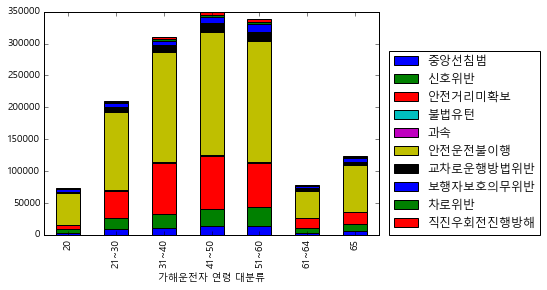

In [35]:
#절댓값으로 그래프 그리기
df.plot.bar(x='가해운전자 연령 대분류',stacked=True).legend(bbox_to_anchor=(1.5, 0.85))
plt.show()

In [31]:
df_per = df.copy()
col_list = list(df_per)
col_list.remove('가해운전자 연령 대분류')
df_per['total'] = df_per[col_list].sum(axis=1)
df_per[col_list] = df_per[col_list].div(df_per.total, axis='index')
df_per = df_per.drop('total', axis=1)

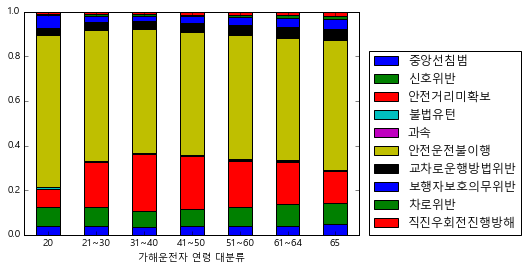

In [34]:
#퍼센트로 그래프 그리기
df_per.plot.bar(x='가해운전자 연령 대분류',stacked=True, rot = 0).legend(bbox_to_anchor=(1.5, 0.85))
plt.show()

# Pie Chart 그리기
## Pie chart 연령

In [6]:
age_data = pd.read_excel('hurt_age_2016.xls')
age_data = age_data.dropna()
age_data.columns = ['연령', '사상여부','사상자수']
age_data = age_data.drop(age_data.where(age_data['연령']=='연령층별').dropna().index)
age_data = age_data.reset_index(drop=True)
hurt_people=[]
for i in range(10):
    hurt_people.append(age_data.iloc[2*i]['사상자수'] + age_data.iloc[2*i+1]['사상자수'])
hurt_people[1:] = hurt_people[1:]/hurt_people[0] * 100

In [7]:
labels = ['14세이하','15-20세','21-30세','31-40세','41-50세','51-60세','61-64세','65세이상']
ratio = hurt_people[1:9]
explode = [0,0,0,0,0,0.1,0,0]
color = ['red', 'orangered','orange','gold','forestgreen','royalblue','magenta','darkorchid']
plt.pie(ratio, labels=labels, colors= color, shadow=True,autopct='%1.1f%%', explode = explode, startangle=90)

plt.show()

# Pie chart 기상

In [9]:
weather_data = pd.read_excel('hurt_weather_2016.xls')
weather_data = weather_data.dropna()
weather_data.columns = ['날씨','사상여부','사상자수']
weather_data = weather_data.drop(weather_data.where(weather_data['날씨']=='기상상태').dropna().index)
weather_data = weather_data.reset_index(drop=True)
hurt_people=[]
for i in range(7):
    hurt_people.append(weather_data.iloc[3*i+1]['사상자수'] + weather_data.iloc[3*i+2]['사상자수'])
hurt_people[1:] = hurt_people[1:]/hurt_people[0] * 100

In [10]:
plt.close()
labels = ['맑음','흐림','비','안개','눈','기타']
ratio = hurt_people[1:]
colors = [ 'orangered','gold','forestgreen','royalblue','magenta','darkorchid']
explode = (0,0,0,0,0,0)
plt.pie(ratio, labels=labels, colors= colors, autopct='%1.1f%%', shadow=True, explode = explode, startangle=90)
plt.show()

# Pie chart 면허 소지자 

In [12]:
license_data = pd.read_excel('license.xls')
license_data.columns = license_data.iloc[0]
cols = ['10대 이하', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대 이상']
cal = []
for i in cols:
    cal.append(license_data.iloc[1][i].sum())
cal = cal/ np.sum(cal)*100

In [13]:
labels = ['', '', '30대', '40대', '50대', '60대', '70대', '', '']
ratio = cal

color = ['red','orange','gold','forestgreen','royalblue','magenta','darkorchid','purple']
plt.pie(ratio, labels=labels, colors = color,  autopct='%1.1f%%', shadow=True,startangle=90)

plt.show()

# 상관관계 분석
## 연령 - 법규위반

In [17]:
age_total = pd.read_excel('age_total.xlsx')
law_total = pd.read_excel('law_total.xlsx')
age_law = pd.merge(age_total, law_total, how = 'outer')

x =  20세이하  y =  중앙선침범
x =  20세이하  y =  신호위반
x =  20세이하  y =  안전거리미확보
x =  20세이하  y =  불법유턴
x =  20세이하  y =  과속
x =  20세이하  y =  안전운전불이행
x =  20세이하  y =  교차로운행방법위반
x =  20세이하  y =  보행자보호의무위반
x =  20세이하  y =  차로위반
x =  20세이하  y =  직진우회전진행방해
x =  20세~30세  y =  중앙선침범
x =  20세~30세  y =  신호위반
x =  20세~30세  y =  안전거리미확보
x =  20세~30세  y =  불법유턴
x =  20세~30세  y =  과속
x =  20세~30세  y =  안전운전불이행
x =  20세~30세  y =  교차로운행방법위반
x =  20세~30세  y =  보행자보호의무위반
x =  20세~30세  y =  차로위반
x =  20세~30세  y =  직진우회전진행방해
x =  30세~40세  y =  중앙선침범


C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


x =  30세~40세  y =  신호위반
x =  30세~40세  y =  안전거리미확보
x =  30세~40세  y =  불법유턴
x =  30세~40세  y =  과속
x =  30세~40세  y =  안전운전불이행
x =  30세~40세  y =  교차로운행방법위반
x =  30세~40세  y =  보행자보호의무위반
x =  30세~40세  y =  차로위반
x =  30세~40세  y =  직진우회전진행방해
x =  40세~50세  y =  중앙선침범
x =  40세~50세  y =  신호위반
x =  40세~50세  y =  안전거리미확보
x =  40세~50세  y =  불법유턴
x =  40세~50세  y =  과속
x =  40세~50세  y =  안전운전불이행
x =  40세~50세  y =  교차로운행방법위반
x =  40세~50세  y =  보행자보호의무위반
x =  40세~50세  y =  차로위반
x =  40세~50세  y =  직진우회전진행방해
x =  50세~60세  y =  중앙선침범
x =  50세~60세  y =  신호위반
x =  50세~60세  y =  안전거리미확보
x =  50세~60세  y =  불법유턴
x =  50세~60세  y =  과속
x =  50세~60세  y =  안전운전불이행
x =  50세~60세  y =  교차로운행방법위반
x =  50세~60세  y =  보행자보호의무위반
x =  50세~60세  y =  차로위반
x =  50세~60세  y =  직진우회전진행방해
x =  60세~64세  y =  중앙선침범
x =  60세~64세  y =  신호위반
x =  60세~64세  y =  안전거리미확보
x =  60세~64세  y =  불법유턴
x =  60세~64세  y =  과속
x =  60세~64세  y =  안전운전불이행
x =  60세~64세  y =  교차로운행방법위반
x =  60세~64세  y =  보행자보호의무위반
x =  60세~64세  y =  차로위반
x =  60세~64세  

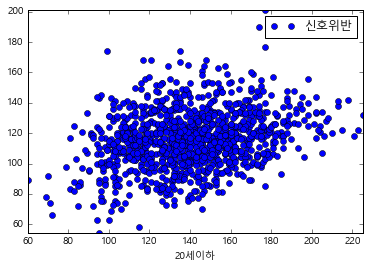

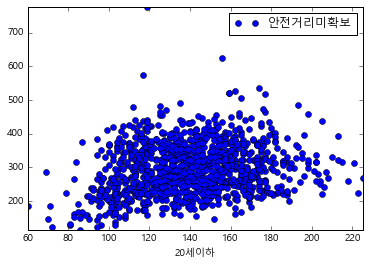

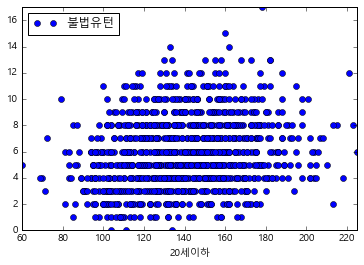

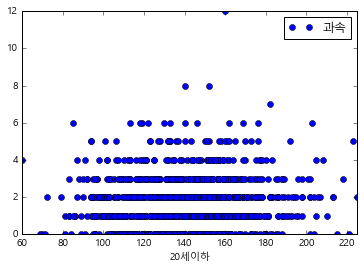

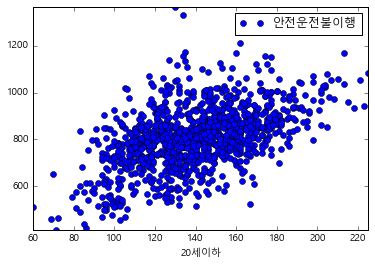

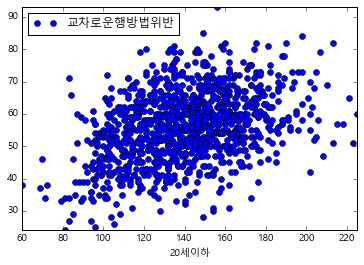

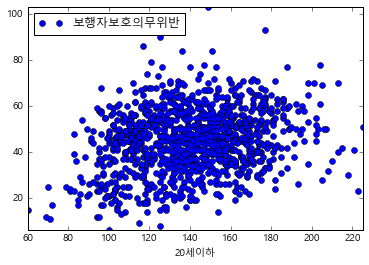

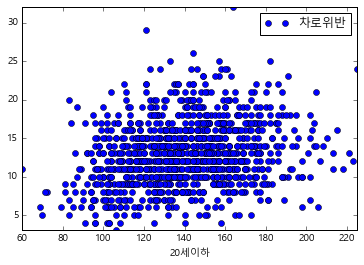

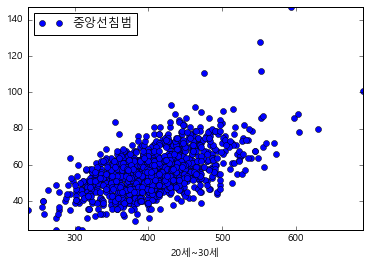

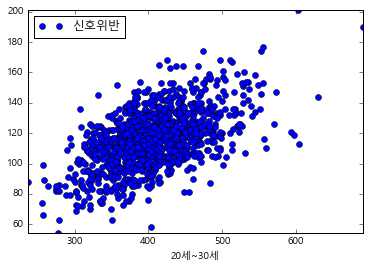

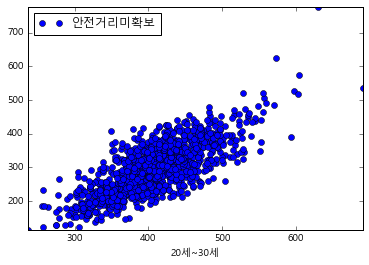

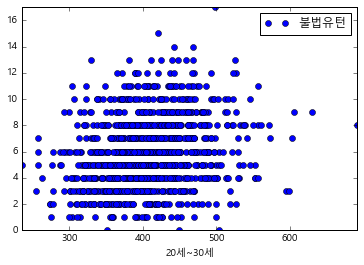

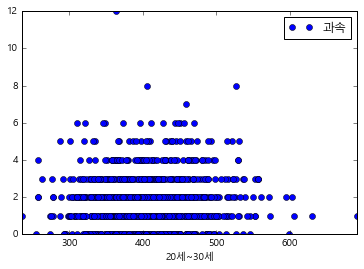

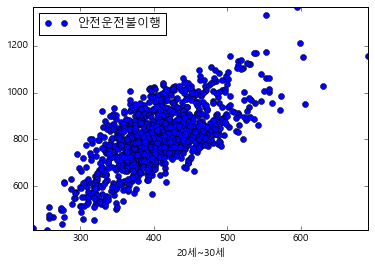

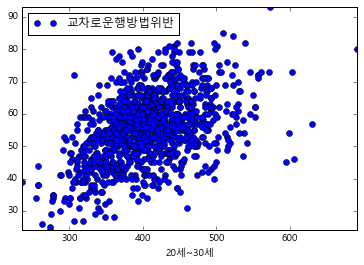

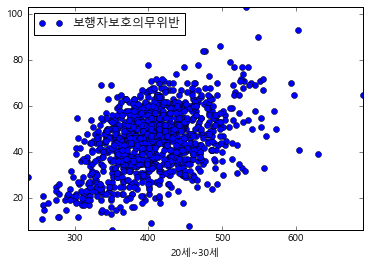

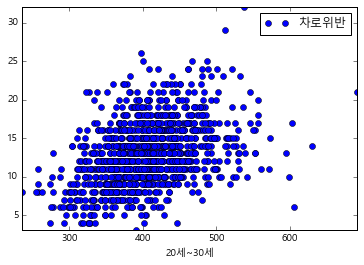

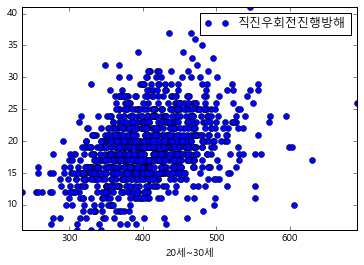

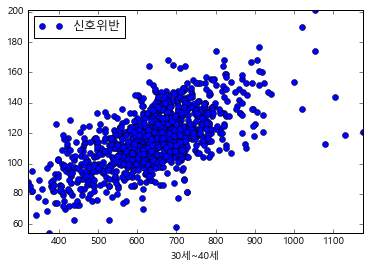

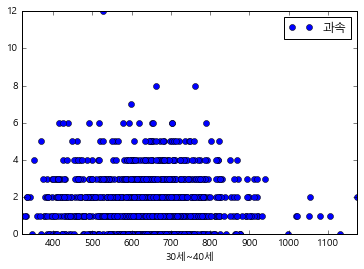

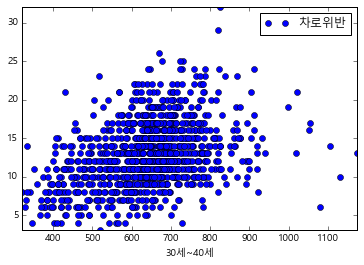

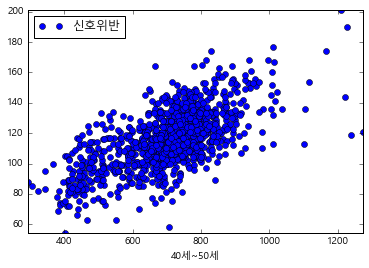

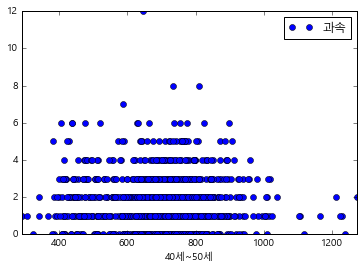

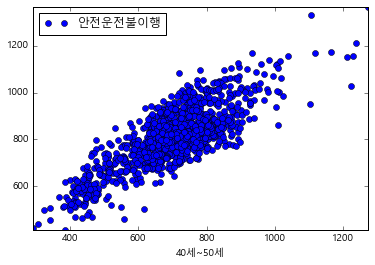

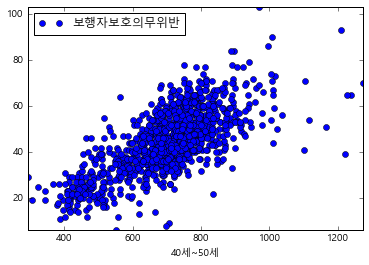

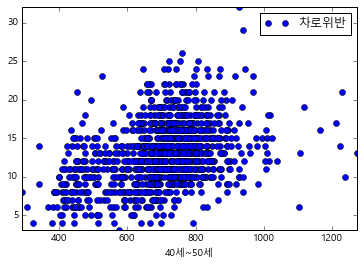

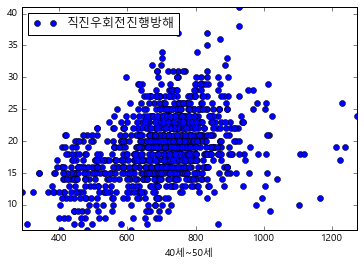

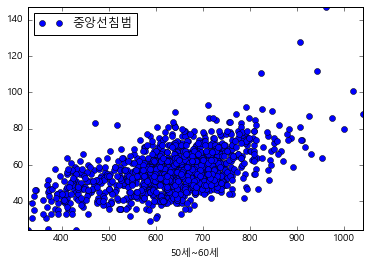

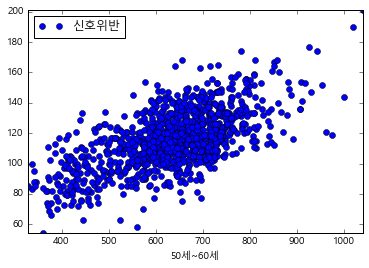

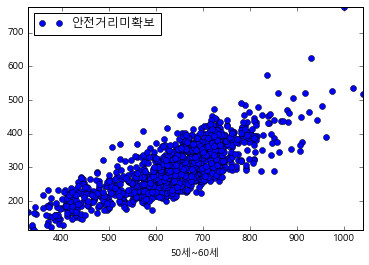

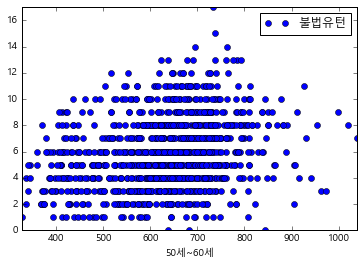

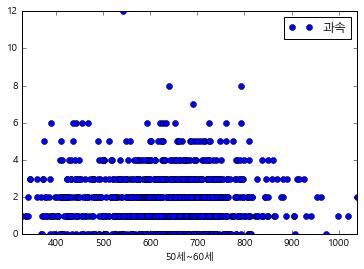

KeyboardInterrupt: 

In [17]:
age_col = ['20세이하', '20세~30세', '30세~40세', '40세~50세', '50세~60세',
       '60세~64세', '65세이상']
law_col = ['중앙선침범', '신호위반', '안전거리미확보', '불법유턴', '과속', '안전운전불이행',
       '교차로운행방법위반', '보행자보호의무위반', '차로위반', '직진우회전진행방해']
for a in age_col:
    for l in law_col:
        print('x = ',a, ' y = ',l)
        age_law.plot(x=a, y=l, linestyle='', marker='o')
        plt.xlim(age_law[a].min(),age_law[a].max())
        plt.ylim(age_law[l].min(),age_law[l].max())
        
        plt.savefig(a+'_'+l+'.png')
        #savefig하면 png로 다 저장됩니다.

In [18]:
for a in age_col:
    for l in law_col:
        x = np.array(age_law[a])
        y = np.array(age_law[l])
        corrcoef = np.corrcoef(x,y)
        print(a ,'와' ,l ,'의 상관계수 = ',corrcoef[0][1])

20세이하 와 중앙선침범 의 상관계수 =  0.269451468342
20세이하 와 신호위반 의 상관계수 =  0.274706104255
20세이하 와 안전거리미확보 의 상관계수 =  0.215918589172
20세이하 와 불법유턴 의 상관계수 =  nan
20세이하 와 과속 의 상관계수 =  0.0634001108253
20세이하 와 안전운전불이행 의 상관계수 =  0.507850169325
20세이하 와 교차로운행방법위반 의 상관계수 =  0.383366121516
20세이하 와 보행자보호의무위반 의 상관계수 =  0.236158679776
20세이하 와 차로위반 의 상관계수 =  0.233219507024
20세이하 와 직진우회전진행방해 의 상관계수 =  0.342240426316
20세~30세 와 중앙선침범 의 상관계수 =  0.564430023335
20세~30세 와 신호위반 의 상관계수 =  0.553260655331
20세~30세 와 안전거리미확보 의 상관계수 =  0.751910838288
20세~30세 와 불법유턴 의 상관계수 =  nan
20세~30세 와 과속 의 상관계수 =  0.0417842082733
20세~30세 와 안전운전불이행 의 상관계수 =  0.68787455476
20세~30세 와 교차로운행방법위반 의 상관계수 =  0.458603270685
20세~30세 와 보행자보호의무위반 의 상관계수 =  0.465357020646
20세~30세 와 차로위반 의 상관계수 =  0.39320310413
20세~30세 와 직진우회전진행방해 의 상관계수 =  0.37230849156
ERROR! Session/line number was not unique in database. History logging moved to new session 418
30세~40세 와 중앙선침범 의 상관계수 =  0.622332066359
30세~40세 와 신호위반 의 상관계수 =  0.651299866937
30세~40세 와 안전거리미확보 의 상관계수 =

# 도로형태 - 법규위반 

In [20]:
road_2014 = pd.read_excel('2014년 도로형태.xlsx')
road_2015 = pd.read_excel('2015년 도로형태.xlsx')
road_2016 = pd.read_excel('2016년 도로형태.xlsx')
law_total = pd.read_excel('law_total.xlsx')

In [21]:
road_total = pd.merge(road_2014, road_2015, how='outer')
road_total = pd.merge(road_total, road_2016, how='outer')
# '-'문자 0으로 바꾸기
road_total['철길건널목'] = road_total['철길건널목'].fillna(0).astype(int)
road_total.columns = ['date', '요일구분', '교차로안', '교차로부근', '횡단보도상', '횡단보도부근', '터널', '교량', '철길건널목'] 
writer = pd.ExcelWriter('road_total.xlsx')
road_total.to_excel(writer,'Sheet1')
writer.save()

x =  교차로안  y =  중앙선침범
x =  교차로안  y =  신호위반
x =  교차로안  y =  안전거리미확보
x =  교차로안  y =  불법유턴
x =  교차로안  y =  과속
x =  교차로안  y =  안전운전불이행
x =  교차로안  y =  교차로운행방법위반
x =  교차로안  y =  보행자보호의무위반
x =  교차로안  y =  차로위반
x =  교차로안  y =  직진우회전진행방해
x =  교차로부근  y =  중앙선침범
x =  교차로부근  y =  신호위반
x =  교차로부근  y =  안전거리미확보
x =  교차로부근  y =  불법유턴
x =  교차로부근  y =  과속
x =  교차로부근  y =  안전운전불이행
x =  교차로부근  y =  교차로운행방법위반
x =  교차로부근  y =  보행자보호의무위반
x =  교차로부근  y =  차로위반


KeyboardInterrupt: 

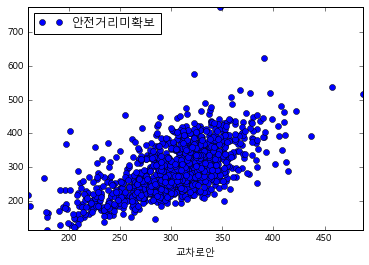

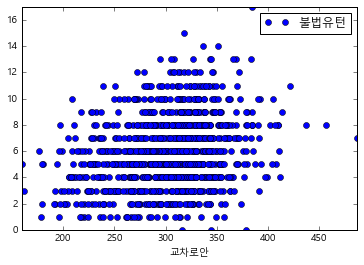

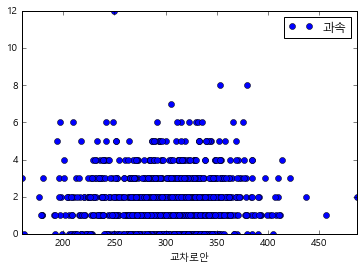

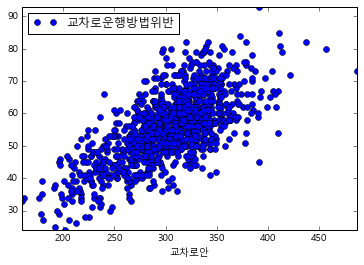

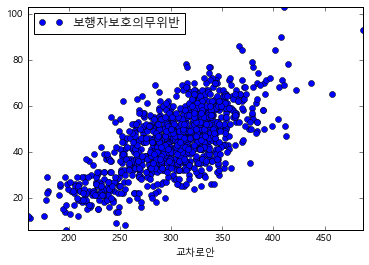

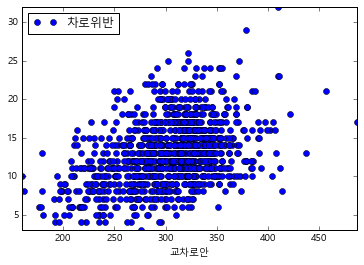

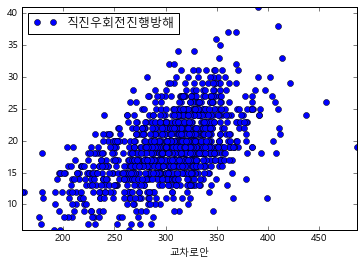

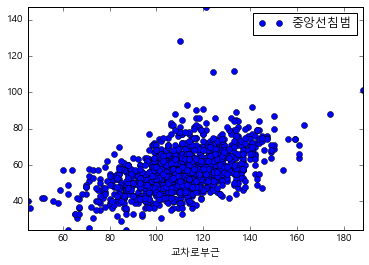

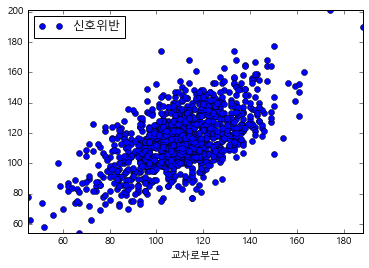

KeyboardInterrupt: 

In [21]:
road_law = pd.merge(road_total, law_total, how='outer')
road_col = ['교차로안', '교차로부근', '횡단보도상', '횡단보도부근', '터널', '교량',
       '철길건널목']
law_col = ['중앙선침범', '신호위반', '안전거리미확보', '불법유턴', '과속', '안전운전불이행',
       '교차로운행방법위반', '보행자보호의무위반', '차로위반', '직진우회전진행방해']

for r in road_col:
    for l in law_col:
        print('x = ',r, ' y = ',l)
        road_law.plot(x=r, y=l, linestyle='', marker='o')
        plt.xlim(road_law[r].min(),road_law[r].max())
        plt.ylim(road_law[l].min(),road_law[l].max())
        
        plt.savefig(r+'_'+l+'.png')

In [23]:
road_col = ['교차로안', '교차로부근', '횡단보도상', '횡단보도부근', '터널', '교량',
       '철길건널목']
law_col = ['중앙선침범', '신호위반', '안전거리미확보', '불법유턴', '과속', '안전운전불이행',
       '교차로운행방법위반', '보행자보호의무위반', '차로위반', '직진우회전진행방해']
for a in road_col:
    for l in law_col:
        x = np.array(road_law[a])
        y = np.array(road_law[l])
        corrcoef = np.corrcoef(x,y)
        print(a ,'와' ,l ,'의 상관계수 = ',corrcoef[0][1])

교차로안 와 중앙선침범 의 상관계수 =  0.541388690205
교차로안 와 신호위반 의 상관계수 =  0.690561907115
교차로안 와 안전거리미확보 의 상관계수 =  0.646077373913
교차로안 와 불법유턴 의 상관계수 =  nan
교차로안 와 과속 의 상관계수 =  0.00598634456145
교차로안 와 안전운전불이행 의 상관계수 =  0.736646208308
교차로안 와 교차로운행방법위반 의 상관계수 =  0.689432997816
교차로안 와 보행자보호의무위반 의 상관계수 =  0.695305012376
교차로안 와 차로위반 의 상관계수 =  0.398488703393
교차로안 와 직진우회전진행방해 의 상관계수 =  0.528852633401
교차로부근 와 중앙선침범 의 상관계수 =  0.521859154431
교차로부근 와 신호위반 의 상관계수 =  0.616289560625
교차로부근 와 안전거리미확보 의 상관계수 =  0.508989624059
교차로부근 와 불법유턴 의 상관계수 =  nan
교차로부근 와 과속 의 상관계수 =  0.0558885697869
교차로부근 와 안전운전불이행 의 상관계수 =  0.667598455959
교차로부근 와 교차로운행방법위반 의 상관계수 =  0.530096393181
교차로부근 와 보행자보호의무위반 의 상관계수 =  0.605101108784
교차로부근 와 차로위반 의 상관계수 =  0.391158681687
교차로부근 와 직진우회전진행방해 의 상관계수 =  0.433333298279
횡단보도상 와 중앙선침범 의 상관계수 =  0.3471691327
횡단보도상 와 신호위반 의 상관계수 =  0.545080520197
횡단보도상 와 안전거리미확보 의 상관계수 =  0.354531442577
횡단보도상 와 불법유턴 의 상관계수 =  nan
횡단보도상 와 과속 의 상관계수 =  0.0316426337704
횡단보도상 와 안전운전불이행 의 상관계수 =  0.543617641897
횡단보도상 와 

## 계절별 산점도

In [1]:
weather_2014 = pd.read_excel('Weather_2014.xlsx')
weather_2015 = pd.read_excel('Weather_2015.xlsx')
weather_2016 = pd.read_excel('Weather_2016.xlsx')
 
road_2014 = pd.read_excel('Road_2014.xlsx')
road_2015 = pd.read_excel('Road_2015.xlsx')
road_2016 = pd.read_excel('Road_2016.xlsx')

weather = pd.concat([weather_2014, weather_2015, weather_2016], axis = 0)
road = pd.concat([road_2014, road_2015, road_2016], axis = 0)

NameError: name 'pd' is not defined

In [ ]:
all_in_one = pd.concat([weather.drop(['요일구분'], axis = 1), road.drop(['날짜', '요일구분'], axis = 1)], axis = 1)
all_in_one = all_in_one.reset_index()
weather_arr = ['맑음', '흐림', '비', '안개', '눈', '기타', '미분류']
road_arr = ['교차로안', '교차로부근', '횡단보도상', '횡단보도부근', '터널', '교량', '철길건널목']

In [ ]:
spring = all_in_one.where(((all_in_one['날짜'] >= 20140301) & (all_in_one['날짜'] < 20140601)) |
                          ((all_in_one['날짜'] >= 20150301) & (all_in_one['날짜'] < 20150601)) |
                          ((all_in_one['날짜'] >= 20160301) & (all_in_one['날짜'] < 20160601))).dropna()
summer = all_in_one.where(((all_in_one['날짜'] >= 20140601) & (all_in_one['날짜'] < 20140901)) |
                          ((all_in_one['날짜'] >= 20150601) & (all_in_one['날짜'] < 20150901)) |
                          ((all_in_one['날짜'] >= 20160601) & (all_in_one['날짜'] < 20160901))).dropna()
autumn = all_in_one.where(((all_in_one['날짜'] >= 20140901) & (all_in_one['날짜'] < 20141201)) |
                          ((all_in_one['날짜'] >= 20150901) & (all_in_one['날짜'] < 20151201)) |
                          ((all_in_one['날짜'] >= 20160901) & (all_in_one['날짜'] < 20161201))).dropna()
winter = all_in_one.where((all_in_one['날짜'] < 20140301) |
                          ((all_in_one['날짜'] >= 20141201) & (all_in_one['날짜'] < 20150301)) |
                          ((all_in_one['날짜'] >= 20151201) & (all_in_one['날짜'] < 20160301)) |
                          (all_in_one['날짜'] >= 20161201)).dropna()

for i in weather_arr:
    for j in road_arr:
        fig = plt.figure()
        plt.hold(True)
        
        plt.scatter(x = spring[i], y = spring[j], color = 'r')
        plt.scatter(x = summer[i], y = summer[j], color = 'g')
        plt.scatter(x = autumn[i], y = autumn[j], color = 'b')
        plt.scatter(x = winter[i], y = winter[j], color = 'y')
        
        plt.xlim(all_in_one[i].min(), all_in_one[i].max())
        plt.ylim(all_in_one[j].min(), all_in_one[j].max())
        
        plt.hold(False)
        
#         plt.savefig('/Users/ldh51/Desktop/bigdata_project/BigData/image/weather_road/3years_ssaw/'+i+'_'+j+'.png')

# 1년 단위의 그래프 그리기

In [ ]:
years = ['2014', '2015', '2016']

for year in years:
    time = pd.read_excel('/Users/ldh51/BigData/time/'+year+'.xlsx')
    weather = pd.read_excel('/Users/ldh51/BigData/weather/'+year+'.xlsx')
    road = pd.read_excel('/Users/ldh51/BigData/road/'+year+'.xlsx')
    rule = pd.read_excel('/Users/ldh51/BigData/rule/'+year+'.xlsx')

    if year == '2014':
        all_2014 = pd.concat([time, weather.drop(['날짜', '요일구분'], axis = 1), 
                              road.drop(['날짜', '요일구분'], axis = 1), 
                              rule.drop(['기타', '미분류', '요일구분'], axis = 1)], axis = 1)
    if year == '2015':
        all_2015 = pd.concat([time, weather.drop(['날짜', '요일구분'], axis = 1), 
                              road.drop(['날짜', '요일구분'], axis = 1), 
                              rule.drop(['기타', '미분류', '요일구분'], axis = 1)], axis = 1)
    if year == '2016':
        all_2016 = pd.concat([time, weather.drop(['날짜', '요일구분'], axis = 1), 
                              road.drop(['날짜', '요일구분'], axis = 1), 
                              rule.drop(['기타', '미분류', '요일구분'], axis = 1)], axis = 1)

In [ ]:
all_2014.plot(x = 'date', y = '합계', color = 'black', figsize = (18, 10))
plt.axvline(x = pd.Timestamp('20140301'), color = 'r');
plt.axvline(x = pd.Timestamp('20140601'), color = 'g');
plt.axvline(x = pd.Timestamp('20140901'), color = 'b');
plt.axvline(x = pd.Timestamp('20141201'), color = 'y');
plt.ylim((0, 5500))
plt.title('2014')
plt.savefig('/Users/ldh51/BigData/image/2014.png')

In [ ]:
all_2015.plot(x = 'date', y = '합계', color = 'black', figsize = (18, 10))
plt.axvline(x = pd.Timestamp('20150301'), color = 'r');
plt.axvline(x = pd.Timestamp('20150601'), color = 'g');
plt.axvline(x = pd.Timestamp('20150901'), color = 'b');
plt.axvline(x = pd.Timestamp('20151201'), color = 'y');
plt.ylim((0, 5500))
plt.title('2015')
plt.savefig('/Users/ldh51/BigData/image/2015.png')

In [ ]:
all_2016.plot(x = 'date', y = '합계', color = 'black', figsize = (18, 10))
plt.axvline(x = pd.Timestamp('20160301'), color = 'r');
plt.axvline(x = pd.Timestamp('20160601'), color = 'g');
plt.axvline(x = pd.Timestamp('20160901'), color = 'b');
plt.axvline(x = pd.Timestamp('20161201'), color = 'y');
plt.ylim((0, 5500))
plt.title('2016')
plt.savefig('/Users/ldh51/BigData/image/2016.png')

# OECD 국가의 행복지수와 사고의 관계

In [26]:
data = pd.read_csv('국가별 교통사고.csv', engine = 'python')
data.columns = data.iloc[1,:]
data = data.drop([0,1])
data.iloc[:,1] = data.iloc[:,1].str.replace('-','0')
data = data.drop(data.columns[2:],axis=1)
happiness = pd.read_excel('OECD 행복지수.xlsx')
df = pd.merge(data,happiness,how='outer')
df = df[df['교통사고발생건수(건)'] != '0']
df.iloc[:,1] = df.iloc[:,1].str.replace(',','').astype(int)
df = df.sort_values('교통사고발생건수(건)')

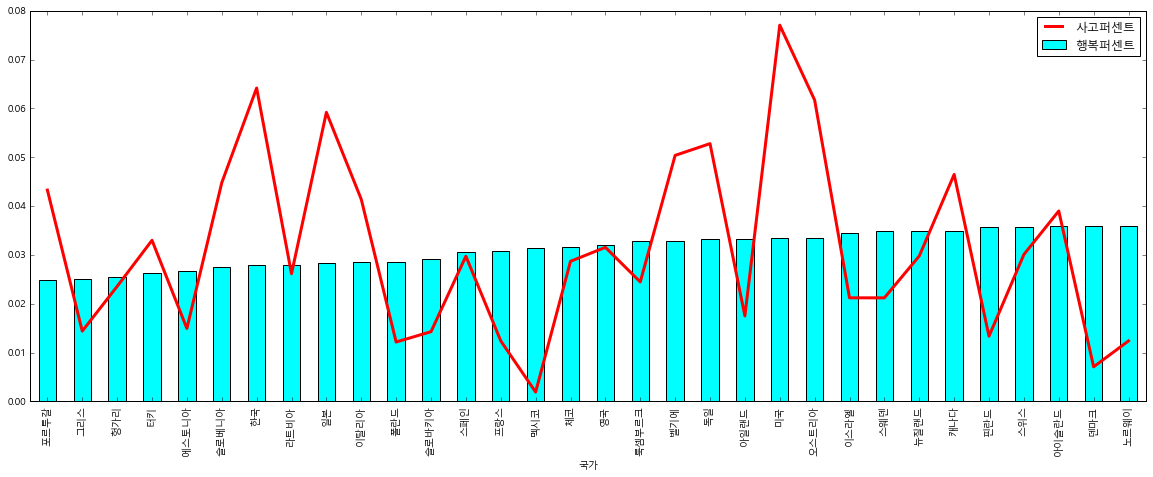

In [27]:
people = pd.read_excel('OECD GDP.xlsx')
del people['2015']
del people['2015.1']
del people['2015.3']
del people['2015.4']
del people['2015.5']
del people['2015.6']
del people['2015.7']
del people['2015.8']
del people['2015.9']
people.columns = ['국가','인구수']
people.iloc[:,0] = people.iloc[:,0].str.replace('\u3000\u3000\u3000','')
df2 = pd.merge(df,people,how='inner')
df2['인구당사고'] = df2['교통사고발생건수(건)']/df2['인구수']
df2 = df2.sort_values('인구당사고')
df2['사고퍼센트'] = df2['인구당사고']/df2['인구당사고'].sum()
df2['행복퍼센트'] = df2['행복지수']/df2['행복지수'].sum()
df2 = df2.sort_values('행복지수')
ax = df2.plot(x='국가', y = '사고퍼센트', color='red', lw=3)
df2.plot.bar(x='국가', y = '행복퍼센트', ax = ax, lw = 1, color='cyan' , width = 0.5 , figsize = (20,7))

plt.show()